## Editing state

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Adding breakpoint before assistant node

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-5-nano")
llm_with_tools = llm.bind_tools(tools)

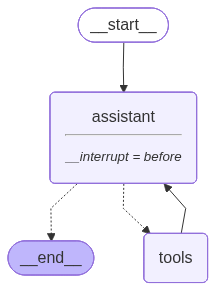

In [6]:
from IPython.display import Image, display 

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, HumanMessage

system_msg = SystemMessage(content = "You are a arithmetic wizard tasked with performing arithmetic operations on a set of inputs.")


# Node
def assistant(state: MessagesState):

    return {"messages": [llm_with_tools.invoke([system_msg] + state["messages"])]}


# Graph

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = InMemorySaver()
graph = builder.compile(interrupt_before=["assistant"],
                        checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
initial_input = {"messages": "Multiply 2 and 3"}

thread = {"configurable": {"thread_id": 1}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [9]:
state = graph.get_state(thread)

In [10]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='172f9778-a924-4541-bd1a-0b96440aba26'), HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='161f5bce-515e-40cb-ad1d-2a6bfc541ec2')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ee559-9799-60b2-8002-f1357be0c74a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-10T18:53:06.299708+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ee559-9796-6fe2-8001-a04767b039d7'}}, tasks=(PregelTask(id='5302292c-a60c-4c1e-f189-4e977d56503a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [11]:
state.next

('assistant',)

In [12]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content = "No, actually mutliplty 3 and 3")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ee563-10c0-6a36-8003-9414b10ec5ad'}}

In [13]:
new_state = graph.get_state(thread).values

In [14]:
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually mutliplty 3 and 3


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually mutliplty 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7rrMtDNM8xAgLHrqZVVDe7V2)
 Call ID: call_7rrMtDNM8xAgLHrqZVVDe7V2
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [16]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

3 × 3 = 9. Would you like to do another calculation?


## Awaiting user input

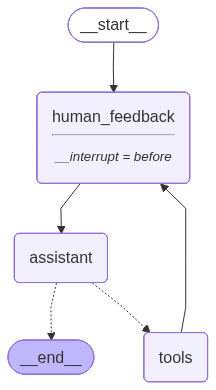

In [25]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display 

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import InMemorySaver

def human_feedback(state: MessagesState):
    # no ops
    pass

def assistant(state: MessagesState):
    system_msg = SystemMessage(content = "You are a helpful arithmetic assistant good at solving problems on a set of inputs.")
    messages = state['messages'] + [system_msg]
    return {"messages": llm_with_tools.invoke(messages)}

builder = StateGraph(MessagesState)
builder.add_node("human_feedback", human_feedback)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant",
                              tools_condition)
builder.add_edge("tools", "human_feedback")

memory = InMemorySaver()
new_graph = builder.compile(checkpointer=memory,
                        interrupt_before= ["human_feedback"])

display(Image(new_graph.get_graph().draw_mermaid_png()))

In [26]:
initial_input = {"messages": "Multiply 2 and 12"}
thread = {'configurable': {"thread_id": 2}}

for event in new_graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

Multiply 2 and 12


In [27]:
state = new_graph.get_state(thread)

In [28]:
state.next

('human_feedback',)

In [29]:
user_input = input("Tell me how you want to update the state.")

new_graph.update_state(thread,
                       {"messages": [user_input]},
                       as_node="human_feedback")
    
for event in new_graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

actually, mutiply 2 and 10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qgfPKtNYwFFTfd3fOFGymb9L)
 Call ID: call_qgfPKtNYwFFTfd3fOFGymb9L
  Args:
    a: 2
    b: 10
================================= Tool Message =================================
Name: multiply

20


In [30]:
for event in new_graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

2 multiplied by 10 equals 20.
